In [1]:
%matplotlib inline

In [2]:
import astropy.units as u
from astropy.convolution import Gaussian1DKernel

from spectral_cube import SpectralCube
from radio_beam import Beam

from regions import Regions



In [3]:
from cube_analysis.feather_cubes import feather_compare_cube

from cube_analysis.reprojection import reproject_cube

from sklearn.mixture import GaussianMixture

from uvcombine.scale_factor import find_scale_factor


In [4]:
from pathlib import Path

sd_data_path = Path("/Users/ekoch/storage/LGLBS/feathering_tests/")
vla_data_path = Path("/Users/ekoch/storage/LGLBS/C+D_HI_2023/")


In [5]:
sc_factors = {}
sc_errs = {}
mix_models = {}

In [6]:
def scalefactor_from_mixturemodel(ratios, ncomp=2, show_plot=False):

    stacked_ratios = np.hstack(ratios)
    stacked_ratios = stacked_ratios[np.isfinite(stacked_ratios)]
    log_ratios = np.log(stacked_ratios).reshape(-1, 1)

    model = GaussianMixture(ncomp).fit(log_ratios)
    
    sc_factor = np.exp(model.means_)
    sc_err = sc_factor * np.sqrt(np.diagonal(model.covariances_))
    
    sc_factor = sc_factor.squeeze()
    sc_err = sc_err.squeeze()
    
    if show_plot:
        x = np.linspace(-5, 5, 1000)
        logprob = model.score_samples(x.reshape(-1, 1))
        responsibilities = model.predict_proba(x.reshape(-1, 1))
        pdf = np.exp(logprob)
        pdf_individual = responsibilities * pdf[:, np.newaxis]

        fig = plt.figure()
        ax = fig.add_subplot(111)
        _ = ax.hist(log_ratios, bins=50, density=True, histtype='stepfilled', alpha=0.4)

        ax.plot(x, pdf, '-k')
        ax.plot(x, pdf_individual, '--k')
        ax.text(0.04, 0.96, "Best-fit Mixture",
                ha='left', va='top', transform=ax.transAxes)

        ax.set_xlabel('log Ratio')
        ax.set_ylabel('PDF')

    
    return sc_factor, sc_err, model


# WLM

In [7]:
vla_cube = SpectralCube.read(vla_data_path / "wlm_C+D_hilores.fits")
vla_cube.allow_huge_operations = True

gbt_cube = SpectralCube.read(sd_data_path / "WLM_GBT.FITS")

In [8]:
beam_ratio = gbt_cube.beam.sr / vla_cube.beam.sr
print(beam_ratio)

588.1524240532295


In [9]:
# Make a cut out to avoid the noisy edges in the GBT map

gbt_region = Regions.read(sd_data_path / "wlm_gbt_cutout.reg")
print(gbt_region)
gbt_cube = gbt_cube.subcube_from_regions(gbt_region)  

[<RectangleSkyRegion(center=<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (0.48514404, -15.44499637)>, width=7008.7108 arcsec, height=6889.2452 arcsec, angle=0.0 deg)>]


In [10]:
gbt_cube.beam.major.to(u.arcmin)

<Quantity 8.703 arcmin>

In [11]:
gbt_cube = gbt_cube.with_spectral_unit(u.km / u.s, velocity_convention='radio')
gbt_cube_specinterp = gbt_cube.spectral_interpolate(vla_cube.spectral_axis) 

In [13]:
output_filename = "wlm_gbt_matched_to_C+D_hilores.fits"

try:
    (sd_data_path / output_filename).unlink()
except FileNotFoundError:
    pass

reproject_cube(gbt_cube_specinterp.hdu, vla_cube.hdu,
               output_filename,
               output_folder=sd_data_path,
               reproject_type='spatial',
               reproject_alg='adaptive')

INFO: Creating new FITS file. [cube_analysis.reprojection]
/Users/ekoch/storage/LGLBS/feathering_tests/wlm_gbt_matched_to_C+D_hilores.fits
INFO: Reprojecting and writing. [cube_analysis.reprojection]


In [14]:
gbt_reproj = SpectralCube.read(sd_data_path / output_filename)
gbt_reproj.allow_huge_operations = True

# Multiply by the pb cut-off
gbt_reproj = gbt_reproj.with_mask(np.isfinite(vla_cube))

In [17]:
hi_freq = 1.42040575 * u.GHz
las = (hi_freq.to(u.cm, u.spectral()) / (40 * u.m)).to(u.arcsec, u.dimensionless_angles())

In [18]:
radii, ratios, high_pts, low_pts, chan_out = \
            feather_compare_cube(vla_cube.to(u.K),
                                 gbt_reproj.to(u.K),
                                 las,
                                 lowresfwhm=9.1*u.arcmin,
                                 num_cores=1,
                                 chunk=250,
                                 verbose=True,
                                 # weights=weight,
                                 relax_spectral_check=False,
                                 spec_check_kwargs={'rtol': 0.01})

INFO: On chunk 1 of 1 [cube_analysis.feather_cubes]


1.11+/-0.24


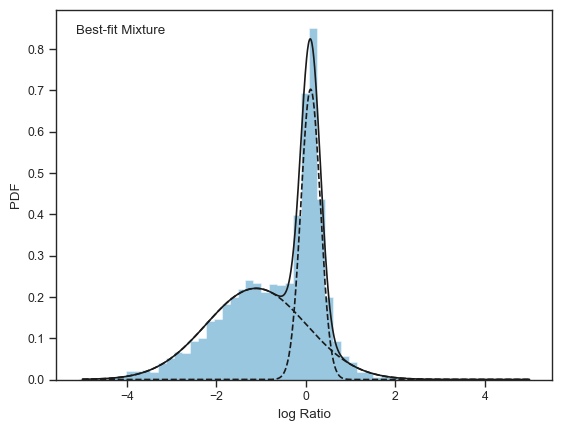

In [42]:
sc_factor, sc_err, model = scalefactor_from_mixturemodel(ratios, ncomp=2, show_plot=True)

print(f"{sc_factor[0]:.2f}+/-{sc_err[0]:.2f}")

gal_name = 'WLM'
sc_factors[gal_name] = sc_factor[0]
sc_errs[gal_name] = sc_err[0]
mix_models[gal_name] = model

# IC10

In [7]:
vla_cube = SpectralCube.read(vla_data_path / "ic10_C+D_hilores.fits")
vla_cube.allow_huge_operations = True

gbt_cube = SpectralCube.read(sd_data_path / "ic10_comb_gal.fits")
gbt_cube = gbt_cube.with_beam(Beam(8.7*u.arcmin))

In [8]:
gbt_cube.beam.major.to(u.arcmin)

<Quantity 8.7 arcmin>

In [9]:
gbt_cube = gbt_cube.with_spectral_unit(u.m / u.s, velocity_convention='radio')

fwhm_factor = np.sqrt(8*np.log(2))
current_resolution = np.abs(np.diff(gbt_cube.spectral_axis)[0]).to(u.km / u.s)
target_resolution = np.abs(np.diff(vla_cube.spectral_axis)[0]).to(u.km / u.s)
print(current_resolution, target_resolution)

gaussian_width = ((target_resolution**2 - current_resolution**2)**0.5 /
                  current_resolution / fwhm_factor)
print(gaussian_width)
kernel = Gaussian1DKernel(gaussian_width.value)
gbt_cube_specsmooth = gbt_cube.spectral_smooth(kernel)


gbt_cube_specinterp = gbt_cube_specsmooth.spectral_interpolate(vla_cube.spectral_axis) 

1.6101500000000233 km / s 4.123524597145006 km / s
1.0012005308118344


In [10]:
# gbt_cube = gbt_cube.with_spectral_unit(u.km / u.s, velocity_convention='radio')
# gbt_cube_specinterp = gbt_cube.spectral_interpolate(vla_cube.spectral_axis) 

In [11]:
output_filename = "ic10_gbt_matched_to_C+D_hilores.fits"

try:
    (sd_data_path / output_filename).unlink()
except FileNotFoundError:
    pass

reproject_cube(gbt_cube_specinterp.hdu, vla_cube.hdu,
               output_filename,
               output_folder=sd_data_path,
               reproject_type='spatial',
               reproject_alg='adaptive')

INFO: Creating new FITS file. [cube_analysis.reprojection]
/Users/ekoch/storage/LGLBS/feathering_tests/ic10_gbt_matched_to_C+D_hilores.fits
INFO: Reprojecting and writing. [cube_analysis.reprojection]


In [12]:
gbt_reproj = SpectralCube.read(sd_data_path / output_filename)
gbt_reproj.allow_huge_operations = True

# Multiply by the pb cut-off
gbt_reproj = gbt_reproj.with_mask(np.isfinite(vla_cube))

In [13]:
hi_freq = 1.42040575 * u.GHz
las = (hi_freq.to(u.cm, u.spectral()) / (40 * u.m)).to(u.arcsec, u.dimensionless_angles())

In [14]:
radii, ratios, high_pts, low_pts, chan_out = \
            feather_compare_cube(vla_cube.to(u.K),
                                 gbt_reproj.to(u.K),
                                 las,
                                 lowresfwhm=None,
                                 num_cores=1,
                                 chunk=250,
                                 verbose=True,
                                 # weights=weight,
                                 relax_spectral_check=False,
                                 spec_check_kwargs={'rtol': 0.01})

INFO: On chunk 1 of 1 [cube_analysis.feather_cubes]


3.50+/-4.57
2.86+/-3.74


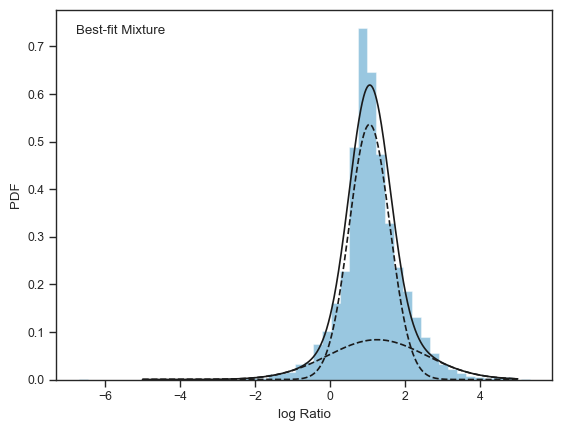

In [15]:
sc_factor, sc_err, model = scalefactor_from_mixturemodel(ratios, ncomp=2, show_plot=True)

print(f"{sc_factor[0]:.2f}+/-{sc_err[0]:.2f}")
print(f"{sc_factor[1]:.2f}+/-{sc_err[1]:.2f}")

gal_name = 'IC10'
sc_factors[gal_name] = sc_factor[1]
sc_errs[gal_name] = sc_err[1]
mix_models[gal_name] = model

In [59]:
# sc_factor, sc_err = find_scale_factor(np.hstack(low_pts), np.hstack(high_pts),
#                                       method='distrib',
#                                       verbose=True)
# print(f"{sc_factor:.2f}\pm{sc_err:.2f}")

<__array_function__ internals>:5: RuntimeWarning: All-NaN axis encountered
<__array_function__ internals>:5: RuntimeWarning: All-NaN axis encountered


Text(0.5, 0.01, 'log Ratio')

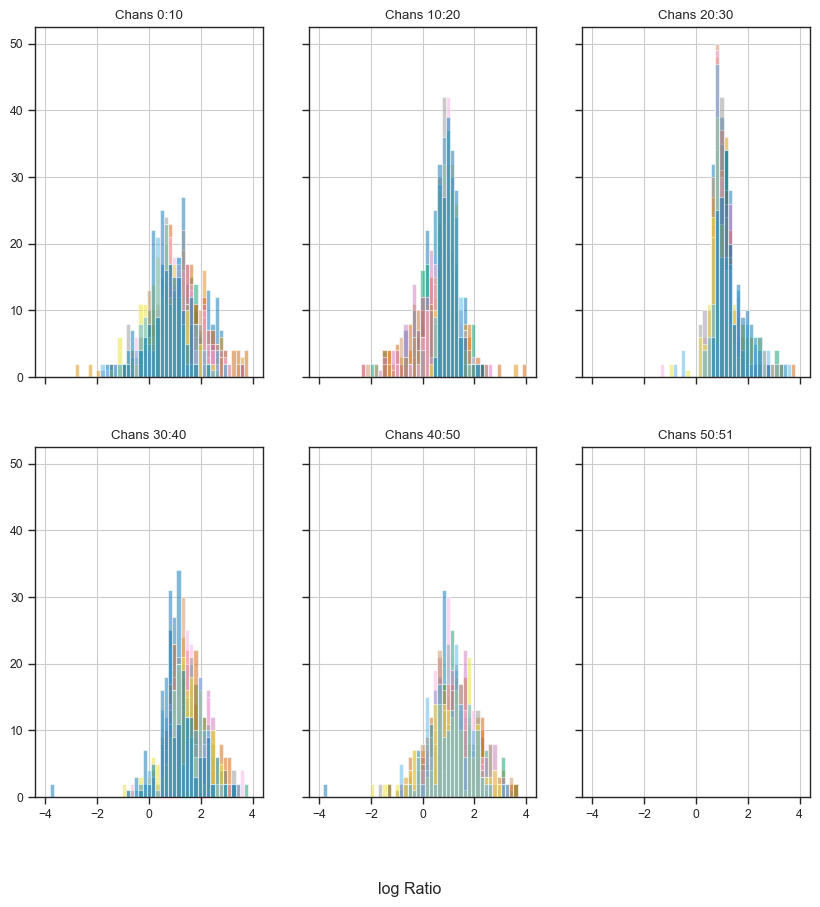

In [60]:
bins = np.linspace(-4, 4, 50)

# for chan in range(len(low_pts)):
#     _ = plt.hist(np.log(ratios[chan]), bins=bins, alpha=0.1)

fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10, 10))

for ii, ax in enumerate(axs.ravel()):

    start = 10 * ii
    end = 10 *(ii+1) + 1
    
    for chan in range(start, end):
        try:
            _ = ax.hist(np.log(ratios[chan]), bins=bins, alpha=0.5)
        except IndexError:
            pass

    ax.set_title(f"Chans {start}:{min(end-1, len(ratios))}")

    ax.grid(True)
    
fig.supxlabel(f"log Ratio")

Text(0.5, 0.01, 'Angular Scale (arcsec)')

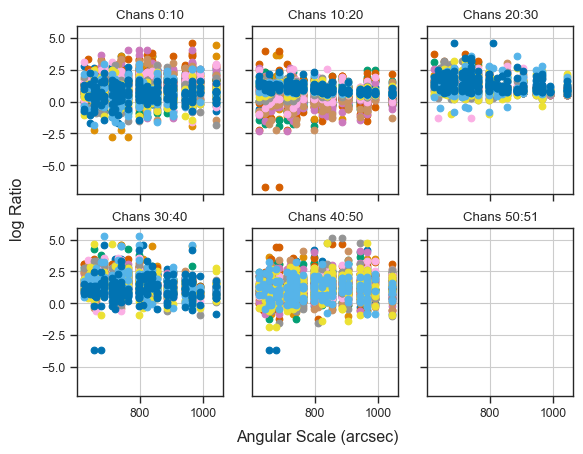

In [61]:
bins = np.linspace(-4, 4, 50)

# for chan in range(len(low_pts)):
#     _ = plt.hist(np.log(ratios[chan]), bins=bins, alpha=0.1)

fig, axs = plt.subplots(2, 3, sharex=True, sharey=True)

for ii, ax in enumerate(axs.ravel()):

    start = 10 * ii
    end = 10 *(ii+1) + 1
    
    for chan in range(start, end):
        try:
            ax.scatter(radii[chan], np.log(ratios[chan]),)
            # ax.scatter(radii[chan], high_pts[chan],)
        except IndexError:
            pass

    ax.set_title(f"Chans {start}:{min(end-1, len(ratios))}")

    ax.grid(True)
    
fig.supylabel(f"log Ratio")
fig.supxlabel(f"Angular Scale ({radii[0].unit})")

/Users/ekoch/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/Users/ekoch/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


Text(0, 0.5, 'Ratio of rms')

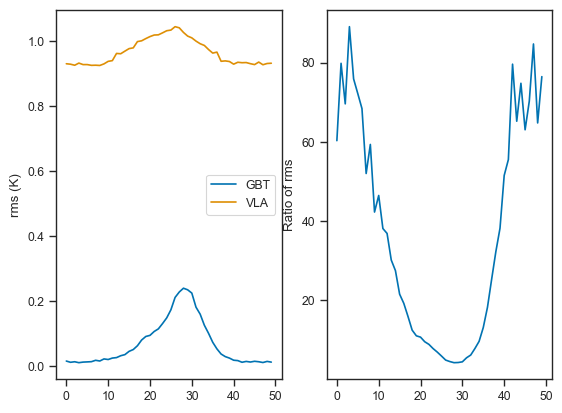

In [71]:
gbt_reproj_madstd = gbt_reproj.to(u.K).mad_std(axis=(1, 2))
vla_madstd = vla_cube.to(u.K).mad_std(axis=(1, 2))

plt.subplot(121)
plt.plot(gbt_reproj_madstd.value, label='GBT')
plt.plot(vla_madstd.value, label='VLA')

plt.ylabel("rms (K)")
plt.legend()

plt.subplot(122)
plt.plot(vla_madstd.value / gbt_reproj_madstd.value, label='VLA / GBT')

plt.ylabel("Ratio of rms")

Text(0, 0.5, 'Ratio of flux')

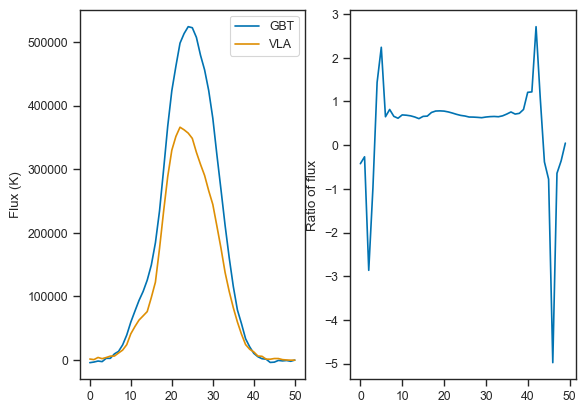

In [73]:
gbt_reproj_sum = gbt_reproj.to(u.K).sum(axis=(1, 2))
# vla_sum = vla_cube.to(u.K).sum(axis=(1, 2))
vla_sum = vla_cube.convolve_to(gbt_cube.beam).to(u.K).sum(axis=(1, 2))

plt.subplot(121)
plt.plot(gbt_reproj_sum.value, label='GBT')
plt.plot(vla_sum.value, label='VLA')

plt.ylabel("Flux (K)")
plt.legend()

plt.subplot(122)
plt.plot(vla_sum.value / gbt_reproj_sum.value, label='VLA / GBT')

plt.ylabel("Ratio of flux")

# IC1613

In [74]:
vla_cube = SpectralCube.read(vla_data_path / "ic1613_C+D_hilores.fits")
vla_cube.allow_huge_operations = True

gbt_cube = SpectralCube.read(sd_data_path / "IC1613_GBT.FITS")
# gbt_cube = gbt_cube.with_beam(Beam(8.7*u.arcmin))


In [89]:
vla_cube

SpectralCube with shape=(51, 1920, 1800) and unit=Jy / beam:
 n_x:   1800  type_x: RA---SIN  unit_x: deg    range:    15.323823 deg:   17.075400 deg
 n_y:   1920  type_y: DEC--SIN  unit_y: deg    range:     1.184156 deg:    3.049933 deg
 n_s:     51  type_s: VRAD      unit_s: m / s  range:  -341144.203 m / s: -134967.973 m / s

In [81]:
gbt_cube

SpectralCube with shape=(87, 128, 128) and unit=Jy / beam:
 n_x:    128  type_x: RA---SFL  unit_x: deg    range:    14.324712 deg:   18.037722 deg
 n_y:    128  type_y: DEC--SFL  unit_y: deg    range:     0.251111 deg:    3.955278 deg
 n_s:     87  type_s: VRAD-F2F  unit_s: km / s  range:     -348.448 km / s:      94.677 km / s

In [75]:
gbt_cube.beam.major.to(u.arcmin)

<Quantity 8.7 arcmin>

In [76]:
gbt_cube = gbt_cube.with_spectral_unit(u.km / u.s, velocity_convention='radio')
gbt_cube_specinterp = gbt_cube.spectral_interpolate(vla_cube.spectral_axis) 

In [77]:
output_filename = "ic1613_gbt_matched_to_C+D_hilores.fits"

try:
    (sd_data_path / output_filename).unlink()
except FileNotFoundError:
    pass

reproject_cube(gbt_cube_specinterp.hdu, vla_cube.hdu,
               output_filename,
               output_folder=sd_data_path,
               reproject_type='spatial',
               reproject_alg='adaptive')

INFO: Creating new FITS file. [cube_analysis.reprojection]
/Users/ekoch/storage/LGLBS/feathering_tests/ic1613_gbt_matched_to_C+D_hilores.fits
INFO: Reprojecting and writing. [cube_analysis.reprojection]


In [78]:
gbt_reproj = SpectralCube.read(sd_data_path / output_filename)
gbt_reproj.allow_huge_operations = True

# Multiply by the pb cut-off
gbt_reproj = gbt_reproj.with_mask(np.isfinite(vla_cube))

In [79]:
hi_freq = 1.42040575 * u.GHz
las = (hi_freq.to(u.cm, u.spectral()) / (40 * u.m)).to(u.arcsec, u.dimensionless_angles())

In [82]:
radii, ratios, high_pts, low_pts, chan_out = \
            feather_compare_cube(vla_cube.to(u.K),
                                 gbt_reproj.to(u.K),
                                 las,
                                 lowresfwhm=None,
                                 num_cores=1,
                                 chunk=250,
                                 verbose=True,
                                 # weights=weight,
                                 relax_spectral_check=False,
                                 spec_check_kwargs={'rtol': 0.01})

INFO: On chunk 1 of 1 [cube_analysis.feather_cubes]


0.94+/-0.86


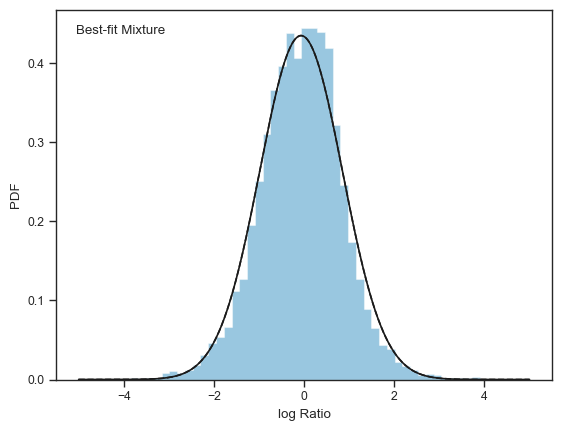

In [87]:
sc_factor, sc_err, model = scalefactor_from_mixturemodel(ratios, ncomp=1, show_plot=True)

print(f"{sc_factor:.2f}+/-{sc_err:.2f}")
# print(f"{sc_factor[0]:.2f}+/-{sc_err[0]:.2f}")
# print(f"{sc_factor[1]:.2f}+/-{sc_err[1]:.2f}")

gal_name = 'IC1613'
# sc_factors[gal_name] = sc_factor[1]
# sc_errs[gal_name] = sc_err[1]
mix_models[gal_name] = model

In [85]:
# sc_factor, sc_err = find_scale_factor(np.hstack(low_pts), np.hstack(high_pts),
#                                       method='distrib',
#                                       verbose=True)
# print(f"{sc_factor:.2f}\pm{sc_err:.2f}")

<__array_function__ internals>:5: RuntimeWarning: All-NaN axis encountered
<__array_function__ internals>:5: RuntimeWarning: All-NaN axis encountered


Text(0.5, 0.01, 'log Ratio')

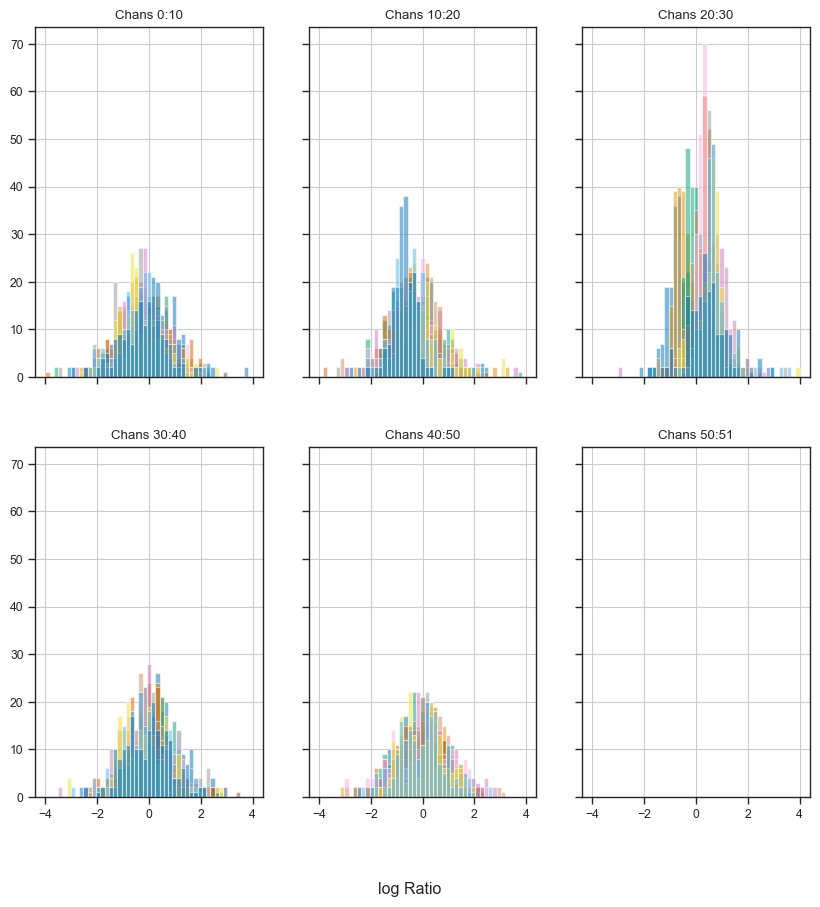

In [88]:
bins = np.linspace(-4, 4, 50)

# for chan in range(len(low_pts)):
#     _ = plt.hist(np.log(ratios[chan]), bins=bins, alpha=0.1)

fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10, 10))

for ii, ax in enumerate(axs.ravel()):

    start = 10 * ii
    end = 10 *(ii+1) + 1
    
    for chan in range(start, end):
        try:
            _ = ax.hist(np.log(ratios[chan]), bins=bins, alpha=0.5)
        except IndexError:
            pass

    ax.set_title(f"Chans {start}:{min(end-1, len(ratios))}")

    ax.grid(True)
    
fig.supxlabel(f"log Ratio")

Text(0.5, 0.01, 'Angular Scale (arcsec)')

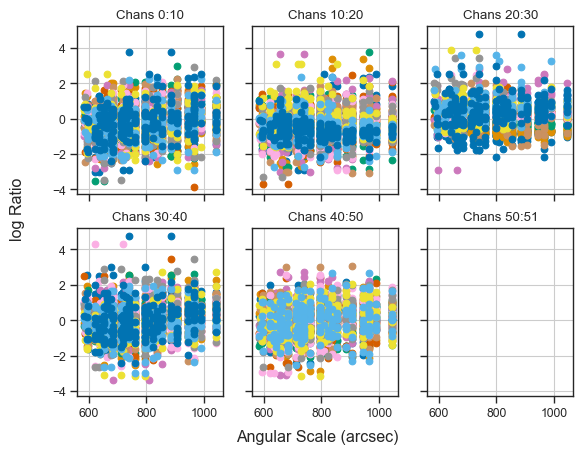

In [91]:
bins = np.linspace(-4, 4, 50)

# for chan in range(len(low_pts)):
#     _ = plt.hist(np.log(ratios[chan]), bins=bins, alpha=0.1)

fig, axs = plt.subplots(2, 3, sharex=True, sharey=True)

for ii, ax in enumerate(axs.ravel()):

    start = 10 * ii
    end = 10 *(ii+1) + 1
    
    for chan in range(start, end):
        try:
            ax.scatter(radii[chan], np.log(ratios[chan]),)
            # ax.scatter(radii[chan], high_pts[chan],)
        except IndexError:
            pass

    ax.set_title(f"Chans {start}:{min(end-1, len(ratios))}")

    ax.grid(True)
    
fig.supylabel(f"log Ratio")
fig.supxlabel(f"Angular Scale ({radii[0].unit})")

Text(0, 0.5, 'Ratio of flux')

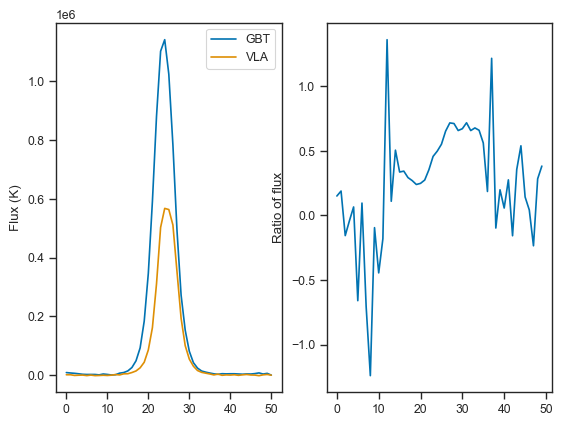

In [92]:
gbt_reproj_sum = gbt_reproj.to(u.K).sum(axis=(1, 2))
# vla_sum = vla_cube.to(u.K).sum(axis=(1, 2))
vla_sum = vla_cube.convolve_to(gbt_cube.beam).to(u.K).sum(axis=(1, 2))

plt.subplot(121)
plt.plot(gbt_reproj_sum.value, label='GBT')
plt.plot(vla_sum.value, label='VLA')

plt.ylabel("Flux (K)")
plt.legend()

plt.subplot(122)
plt.plot(vla_sum.value / gbt_reproj_sum.value, label='VLA / GBT')

plt.ylabel("Ratio of flux")

# NGC6822

In [7]:
vla_cube = SpectralCube.read(vla_data_path / "ngc6822_C+D_hilores.fits")
vla_cube.allow_huge_operations = True

gbt_cube = SpectralCube.read(sd_data_path / "N6822_GBT.FITS")
# gbt_cube = gbt_cube.with_beam(Beam(8.7*u.arcmin))


In [8]:
gbt_cube.beam.major.to(u.arcmin)

<Quantity 8.7054 arcmin>

In [9]:
vla_cube

SpectralCube with shape=(51, 2304, 2400) and unit=Jy / beam:
 n_x:   2400  type_x: RA---SIN  unit_x: deg    range:   295.376058 deg:  297.105829 deg
 n_y:   2304  type_y: DEC--SIN  unit_y: deg    range:   -15.601865 deg:  -14.002517 deg
 n_s:     51  type_s: VRAD      unit_s: m / s  range:  -147144.203 m / s:   59032.027 m / s

In [10]:
gbt_cube

SpectralCube with shape=(1084, 60, 60) and unit=K:
 n_x:     60  type_x: GLON-SFL  unit_x: deg    range:    23.475367 deg:   27.141398 deg
 n_y:     60  type_y: GLAT-SFL  unit_y: deg    range:   -20.149150 deg:  -16.707483 deg
 n_s:   1084  type_s: VRAD      unit_s: m / s  range:  -589854.131 m / s:  456533.145 m / s

In [23]:
gbt_cube = gbt_cube.with_spectral_unit(u.m / u.s, velocity_convention='radio')

fwhm_factor = np.sqrt(8*np.log(2))
current_resolution = np.abs(np.diff(gbt_cube.spectral_axis)[0]).to(u.km / u.s)
target_resolution = np.abs(np.diff(vla_cube.spectral_axis)[0]).to(u.km / u.s)

gaussian_width = ((target_resolution**2 - current_resolution**2)**0.5 /
                  current_resolution / fwhm_factor)
print(gaussian_width)
kernel = Gaussian1DKernel(gaussian_width.value)
gbt_cube_specsmooth = gbt_cube.spectral_smooth(kernel)


gbt_cube_specinterp = gbt_cube_specsmooth.spectral_interpolate(vla_cube.spectral_axis) 

1.7619160729501018


In [24]:
output_filename = "ngc6822_gbt_matched_to_C+D_hilores.fits"

try:
    (sd_data_path / output_filename).unlink()
except FileNotFoundError:
    pass

reproject_cube(gbt_cube_specinterp.hdu, vla_cube.hdu,
               output_filename,
               output_folder=sd_data_path,
               reproject_type='spatial',
               reproject_alg='adaptive')

INFO: Creating new FITS file. [cube_analysis.reprojection]
/Users/ekoch/storage/LGLBS/feathering_tests/ngc6822_gbt_matched_to_C+D_hilores.fits
INFO: Reprojecting and writing. [cube_analysis.reprojection]


In [25]:
gbt_reproj = SpectralCube.read(sd_data_path / output_filename)
gbt_reproj.allow_huge_operations = True

# Multiply by the pb cut-off
gbt_reproj = gbt_reproj.with_mask(np.isfinite(vla_cube))

In [26]:
hi_freq = 1.42040575 * u.GHz
las = (hi_freq.to(u.cm, u.spectral()) / (40 * u.m)).to(u.arcsec, u.dimensionless_angles())

In [27]:
radii, ratios, high_pts, low_pts, chan_out = \
            feather_compare_cube(vla_cube.to(u.K),
                                 gbt_reproj.to(u.K),
                                 las,
                                 lowresfwhm=None,
                                 num_cores=1,
                                 chunk=250,
                                 verbose=True,
                                 # weights=weight,
                                 relax_spectral_check=False,
                                 spec_check_kwargs={'rtol': 0.01})

INFO: On chunk 1 of 1 [cube_analysis.feather_cubes]


1.87+/-1.10
0.07+/-0.04


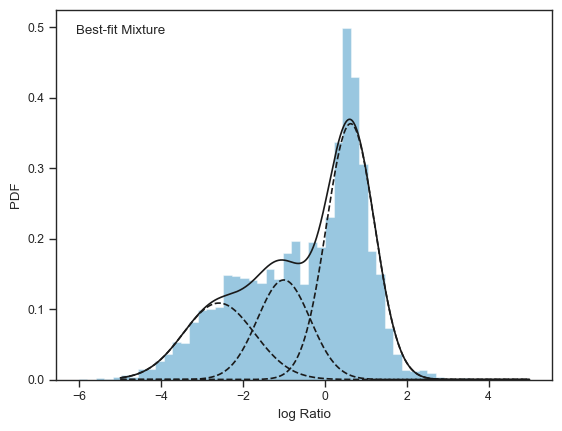

In [43]:
sc_factor, sc_err, model = scalefactor_from_mixturemodel(ratios, ncomp=3, show_plot=True)

# print(f"{sc_factor:.2f}+/-{sc_err:.2f}")
print(f"{sc_factor[0]:.2f}+/-{sc_err[0]:.2f}")
print(f"{sc_factor[1]:.2f}+/-{sc_err[1]:.2f}")

gal_name = 'NGC6822'
# sc_factors[gal_name] = sc_factor[1]
# sc_errs[gal_name] = sc_err[1]
mix_models[gal_name] = model

2.02+/-0.67
2.13+/-0.71


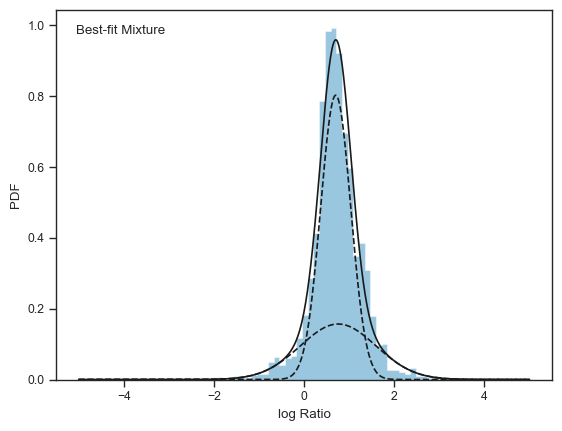

In [31]:
sc_factor, sc_err, model = scalefactor_from_mixturemodel(ratios[17:35], ncomp=2, show_plot=True)

# print(f"{sc_factor:.2f}+/-{sc_err:.2f}")
print(f"{sc_factor[0]:.2f}+/-{sc_err[0]:.2f}")
print(f"{sc_factor[1]:.2f}+/-{sc_err[1]:.2f}")

gal_name = 'NGC6822'
# sc_factors[gal_name] = sc_factor[1]
# sc_errs[gal_name] = sc_err[1]
mix_models[gal_name] = model

<__array_function__ internals>:5: RuntimeWarning: All-NaN axis encountered
<__array_function__ internals>:5: RuntimeWarning: All-NaN axis encountered


Text(0.5, 0.01, 'log Ratio')

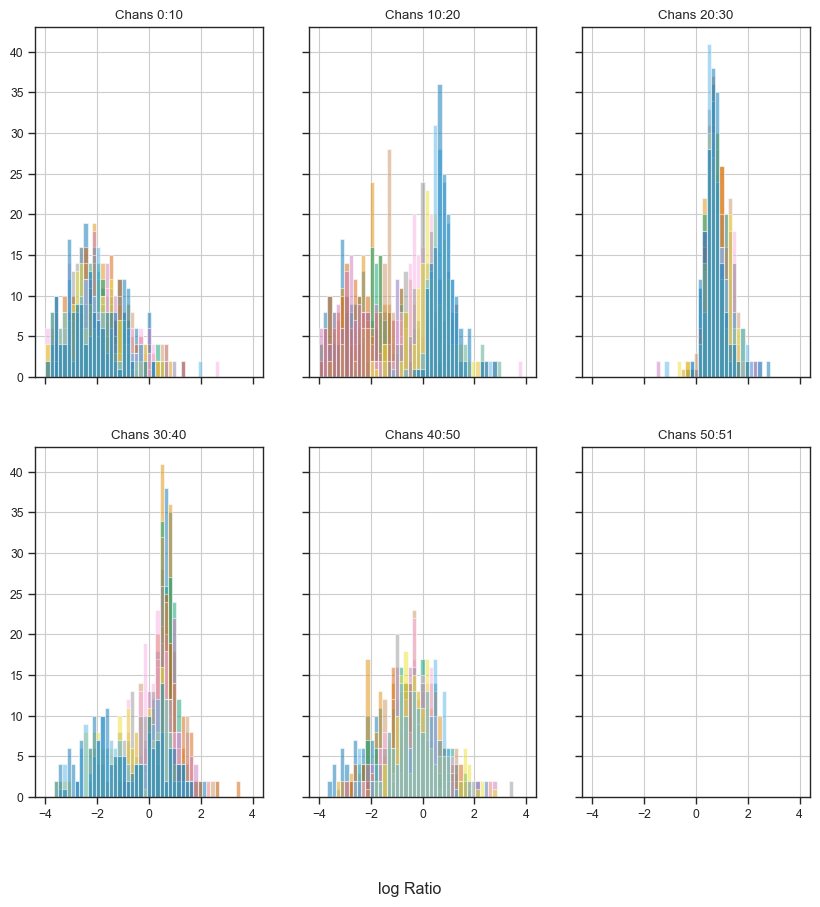

In [29]:
bins = np.linspace(-4, 4, 50)

# for chan in range(len(low_pts)):
#     _ = plt.hist(np.log(ratios[chan]), bins=bins, alpha=0.1)

fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10, 10))

for ii, ax in enumerate(axs.ravel()):

    start = 10 * ii
    end = 10 *(ii+1) + 1
    
    for chan in range(start, end):
        try:
            _ = ax.hist(np.log(ratios[chan]), bins=bins, alpha=0.5)
        except IndexError:
            pass

    ax.set_title(f"Chans {start}:{min(end-1, len(ratios))}")

    ax.grid(True)
    
fig.supxlabel(f"log Ratio")

In [104]:
sc_err

array([0.47295021, 0.08183417])

In [41]:
# np.nansum(gbt_reproj[33].to(u.Jy / u.beam))
np.nansum(gbt_reproj[33].to(u.K))

<Slice 3067836.53192691 K>

In [40]:
# np.nansum(vla_cube[33].to(u.Jy / u.beam))
np.nansum(vla_cube[33].to(u.K))

<Slice 1293950.70131316 K>

In [42]:
np.nansum(vla_cube[33].to(u.K)) / np.nansum(gbt_reproj[33].to(u.K))

<Slice 0.42177955>